https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [33]:
df = pd.read_csv('creditcard.csv')
df.head()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,182545,125447.0,1.816429,0.146354,0.046576,3.598831,-0.119489,0.764143,-0.673691,0.375930,...,0.235474,0.539597,0.240714,0.691290,-0.349606,-0.055401,-0.011830,-0.033766,18.92,0
1,264950,161666.0,-1.132632,-0.217753,-1.018984,-0.725154,1.624606,-1.123202,0.151016,0.322056,...,0.439623,0.855120,-0.058180,0.115257,-0.786822,0.591033,0.308595,0.055496,24.95,0
2,278614,168323.0,1.754189,0.230348,0.019154,3.927093,-0.087202,0.227146,-0.115704,0.053371,...,-0.374842,-1.136878,0.441901,-0.183241,-0.580846,-0.508929,-0.005608,-0.019285,64.40,0
3,10160,15578.0,1.028419,0.252588,1.744422,2.801771,-0.613426,0.860407,-0.849896,0.375564,...,-0.148324,-0.044123,0.103698,0.142224,0.132222,-0.080803,0.026917,0.016913,0.00,0
4,64,42.0,-0.522666,1.009923,0.276470,1.475289,-0.707013,0.355243,1.559849,-0.399579,...,0.172401,1.011543,0.069666,0.157820,-1.109224,-0.302369,0.318170,0.316910,243.66,0


In [34]:
# check null values
df.isnull().sum().max()

0

In [49]:
len(df[df.Class==0])

85282

In [50]:
len(df[df.Class==1])

160

In [35]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# using original to distinguish and to not overwrite these variables.by train_test_split()
for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

No Frauds 99.81 % of the dataset
Frauds 0.19 % of the dataset
Train: [79133 81572 61354 ... 60995 26303 73589] Test: [51562 56990 16218 ... 61393 53361  7473]
Train: [42114 54427 15331 ... 17421 36736 35121] Test: [73088 28317 17535 ... 67458  1816 22465]
Train: [25666 14318 31670 ... 72231 59172 44048] Test: [60085 37617 23474 ... 43700  9063  7545]
Train: [49839 82199 61200 ... 13698 14921 70859] Test: [ 1246 68398 47337 ... 31261 37614  8213]
Train: [72741 78570  3860 ...  3133  7721 84137] Test: [53234 80009 60774 ...  4299 66204 41739]


In [37]:
# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99812737 0.00187263]
[0.99812745 0.00187255]


# Dimensionality Reduction and Clustering:

### Understanding t-SNE:
In order to understand this algorithm you have to understand the following terms: 
- Euclidean Distance
- Conditional Probability
- Normal and T-Distribution Plots

### Summary:
- t-SNE algorithm can pretty accurately cluster the cases that were fraud and non-fraud in our dataset.
- Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately **in every scenario **(I shuffle the dataset before running t-SNE)
- This gives us an indication that further predictive models will perform pretty well in separating fraud cases from non-fraud cases.

### 在原始数据上看分布

In [38]:
# 数据降维
def transfor(X,y):
    print("length of X is =" +len(X)+"length of y is ="+len(y))
    # T-SNE Implementation
    t0 = time.time()
    X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
    t1 = time.time()
    print("T-SNE took {:.2} s".format(t1 - t0))

    # PCA Implementation
    t0 = time.time()
    X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
    t1 = time.time()
    print("PCA took {:.2} s".format(t1 - t0))

    # TruncatedSVD
    t0 = time.time()
    X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
    t1 = time.time()
    print("Truncated SVD took {:.2} s".format(t1 - t0))

transfor(X,y)
# 感觉运行了一辈子,1300s = 20mins 

85442 85442
T-SNE took 1.3e+03 s
PCA took 0.43 s
Truncated SVD took 0.31 s


In [42]:
print(len(X_reduced_tsne),len(X_reduced_pca),len(X_reduced_svd))

480 480 480


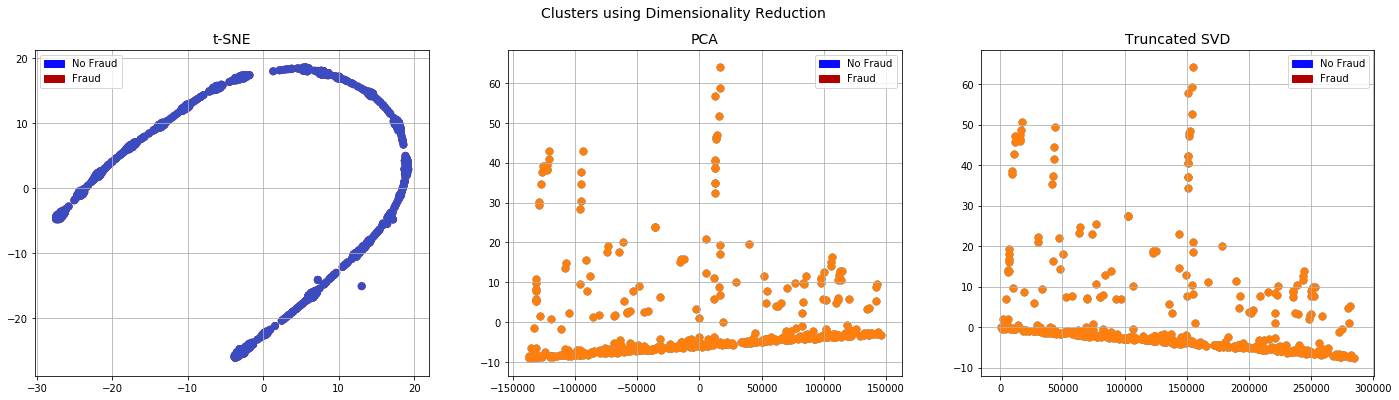

In [53]:
def plot(X_reduced_tsne,X_reduced_pca,X_reduced_svd):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
    # labels = ['No Fraud', 'Fraud']
    f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


    blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
    red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

    # c=(y == 0),但是降维后的X_reduced_tsne变成了480个，而c=（y==0）还是两万多个，就报错。
    # t-SNE scatter plot
    ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1] , cmap='coolwarm', label='No Fraud', linewidths=2)
    ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], cmap='coolwarm', label='Fraud', linewidths=2)
    ax1.set_title('t-SNE', fontsize=14)

    ax1.grid(True)

    ax1.legend(handles=[blue_patch, red_patch])


    # PCA scatter plot
    ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], cmap='coolwarm', label='No Fraud', linewidths=2)
    ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1],  cmap='coolwarm', label='Fraud', linewidths=2)
    ax2.set_title('PCA', fontsize=14)

    ax2.grid(True)

    ax2.legend(handles=[blue_patch, red_patch])

    # TruncatedSVD scatter plot
    ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1],  cmap='coolwarm', label='No Fraud', linewidths=2)
    ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1],  cmap='coolwarm', label='Fraud', linewidths=2)
    ax3.set_title('Truncated SVD', fontsize=14)

    ax3.grid(True)

    ax3.legend(handles=[blue_patch, red_patch])

    plt.show()

plot(X_reduced_tsne,X_reduced_pca,X_reduced_svd)

### 以上，原始数据分不太开

# under sampling

In [ ]:
number_frauds=len(data[data.Class==1])
fraud_indices=np.array(data[data.Class==1].index)

normal_indices=data[data.Class==0].index

rand_normal_indices=np.random.choice(normal_indices,number_frauds,replace=False)

# 保留所有fraud的index，和部分选出的unfraud的index，组合起来
under_sample_indices=np.concatenate([fraud_indices,rand_normal_indices])
# 选出下采样后的数据集
under_sample_data=data.iloc[under_sample_indices,:]

X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class'].values
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class'].values.ravel()

# Learning Curves:
- The wider the gap between the training score and the cross validation score, the more likely your model is overfitting (high variance).
- If the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias)